/home/gideonuchehara/anaconda3/envs/ricco-cut/lib/python3.10/site-packages/pennylane/workflow/qnode.py:830: PennyLaneDeprecationWarning: The tape/qtape property is deprecated and will be removed in v0.41. Instead, use the qml.workflow.construct_tape function.
  warnings.warn(


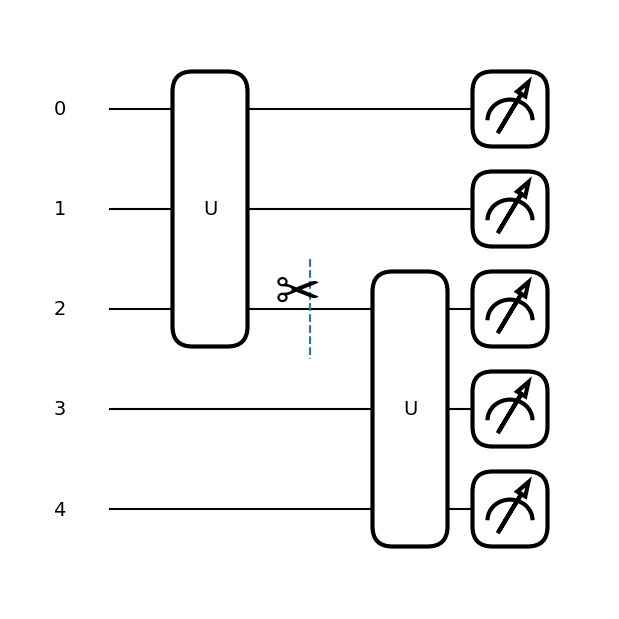

In [1]:
import pennylane as qml
from pennylane import numpy as np
from ricco.utils import generate_random_circuit

num_qubits = 5
num_cuts=1
seed_u = 103
seed_v = 105

# Initialize device for RICCO optimization
dev = qml.device("default.qubit", wires=range(num_qubits))

# Define and create a QNode for the generated quantum circuit
random_circuit_qnode = qml.QNode(generate_random_circuit, device=dev)

# Update QNode and Compute expectation value of the uncut circuit
uncut_random_circuit_expval = random_circuit_qnode(
    num_qubits, num_cuts, seed_u, seed_v)

# Optionally display the uncut circuit
fig1, ax = qml.draw_mpl(random_circuit_qnode)(num_qubits, num_cuts, 
                                              seed_u, seed_v)

tape = random_circuit_qnode.qtape

In [2]:
from ricco.algorithm import RICCO
# Initialize RICCO
ricco = RICCO(random_circuit_qnode, num_cuts, dev, entangling_layers=3)

# Run multiple trials and compute the average expectation value
ricco.run_multiple_trials(iterations=1)

# Access the mean expectation value
print("Mean Expectation Value (from attribute):", ricco.mean_expval)

Optimization complete!
Iteration 1/1, Expectation Value: 0.1408930879312773
Mean Expectation Value over 1 iterations: 0.1408930879312773
Mean Expectation Value (from attribute): 0.1408930879312773


/home/gideonuchehara/anaconda3/envs/ricco-cut/lib/python3.10/site-packages/pennylane/workflow/execution.py:161: PennyLaneDeprecationWarning: gradient_fn has been renamed to diff_method in qml.execute
  warn(


In [3]:
qml.execute([tape], dev)

(0.13896967694463053,)

In [4]:
ricco.update_and_expand_fragment_tapes()
for c in ricco.expanded_tapes:
    print(c.draw(show_matrices=False))
    print()

0: ─╭U(M0)───────────────────────────────┤ ╭<Z@Z@I>
1: ─├U(M0)───────────────────────────────┤ ├<Z@Z@I>
2: ─╰U(M0)──StronglyEntanglingLayers(M1)─┤ ╰<Z@Z@I>

0: ─╭U(M0)───────────────────────────────┤ ╭<Z@Z@Z>
1: ─├U(M0)───────────────────────────────┤ ├<Z@Z@Z>
2: ─╰U(M0)──StronglyEntanglingLayers(M1)─┤ ╰<Z@Z@Z>

2: ──I──StronglyEntanglingLayers(M0)†─╭U(M1)─┤ ╭<Z@Z@Z>
3: ───────────────────────────────────├U(M1)─┤ ├<Z@Z@Z>
4: ───────────────────────────────────╰U(M1)─┤ ╰<Z@Z@Z>

2: ──X──StronglyEntanglingLayers(M0)†─╭U(M1)─┤ ╭<Z@Z@Z>
3: ───────────────────────────────────├U(M1)─┤ ├<Z@Z@Z>
4: ───────────────────────────────────╰U(M1)─┤ ╰<Z@Z@Z>

